# Capstone Three - Adidas Sales Forecasting
## 4. Pre-processing & Modeling

In this part of the project, we'll pre-process and train the data first, and then build models for sales forecasting.

### 4.1 Sourcing & Loading


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv("df.csv", index_col=0)
df.head(3)

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.0,0.50,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.0,0.30,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Women's Street Footwear,40.0,1000,400000.0,140000.0,0.35,In-store


### 4.2 Pre-processing & Modeling 

We are going to use time series models to forecast Adidas' total sales.  To do that, we'll preprocess the date by grouping the Total Sales by Invoice Date, converting the Invoice Data to datetime, setting the Invoice Date as the index, making sure the time series is stationary before building the model.

#### 4.2.1 Preprocessing

In [16]:
# Drop all irrelevant columns to keep "Invoice Date" and "Total Sales" only.
df = df[['Invoice Date', 'Total Sales']]

# Group "Total Sales" by "Invoice Date".  Convert "Invoice Date" to datetime and set it as the index.
df = df.groupby('Invoice Date').agg({'Total Sales': 'sum'}).reset_index()
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
df.set_index('Invoice Date', inplace=True)

# Set the date frequency as "day".
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(date_range)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Sales  724 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


<Axes: >

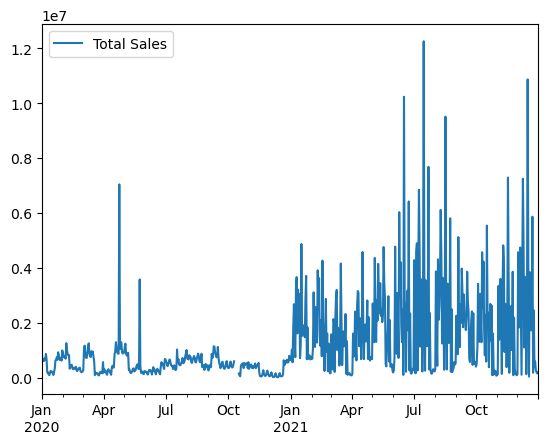

In [17]:
df.plot()

Out of the 2 years' sales data, the 1st year's data seems to be significantly different from the 2nd year in terms of sales density. This is because 2020 is the year Covid started and had the biggest impact on our life. For most of the year, people were locked inside their home. That significantly affected sales volume not just for Adidas but all the retailers selling non-essential merchants. Since our purpose is to forecast future sales, using 2020's sales data will definitely skew our sales forecast. Therefore, we'll drop 2020 data and use the 2021 sales data for forecasting purposes.

In [18]:
df = df[df.index.year == 2021]
print(df.head())
df.info()

            Total Sales
2021-01-01     654902.0
2021-01-02     730614.0
2021-01-03    1030039.0
2021-01-04     572074.0
2021-01-05    1803002.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Sales  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Sales  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: >

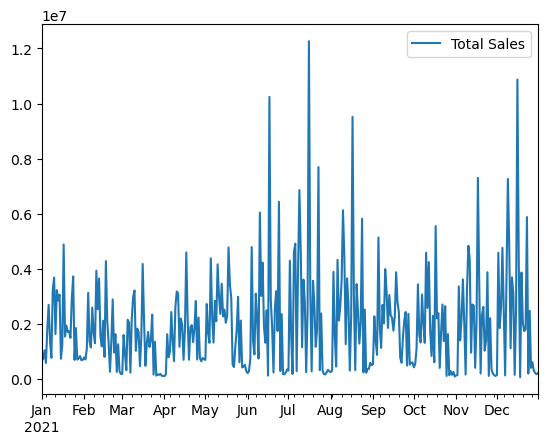

In [20]:
df.plot()

By visualization, we can tell that the data is not stationary because the variance isn't constant.  Therefore, we'll need to transform the data to stabilize the variance.

<Axes: >

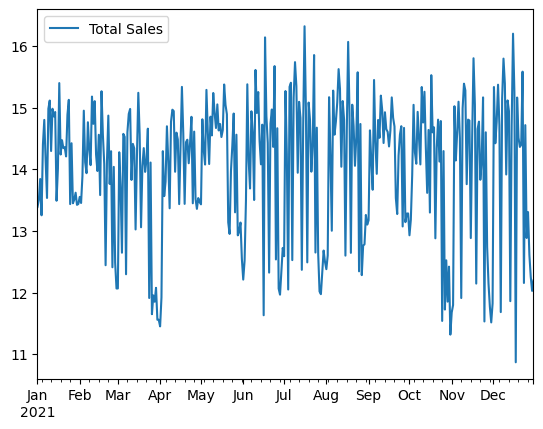

In [21]:
# Transform the series to stablize its variance.
dfl = np.log(df)
dfl.plot()

In [22]:
# Check for stationarity of the transformed time series.
results = adfuller(dfl['Total Sales'])
print('Test statistic: ', results[0])
print('P-value: ', results[1])
print('Critical test statistic: ', results[4])

Test statistic:  -6.306686170620172
P-value:  3.310312316984059e-08
Critical test statistic:  {'1%': -3.449226932880019, '5%': -2.869857365438656, '10%': -2.571201085130664}


Since the test statistic is very negative and p-value is significantly lower than 0.05, we reject the null hypothesis (i.e. non-stationary).  Since the time series is stationary now, we can proceed to modeling.

#### 4.2.2 Training

We'll use a 70/30 split for the training set and test set. 

In [23]:
train_size = 0.7
split_point = int(len(dfl) * train_size)  
print("Number of Train Data: ", split_point, ";   ", "Number of Test Data: ", len(dfl)-split_point)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

Number of Train Data:  255 ;    Number of Test Data:  110


#### 4.2.3 Modeling

In this section, we'll model sales forecast based upon Adidas 2021 sales data.  We'll use 3 time series models including ARIMA (AutoRegressive Integrated Moving Average), SARIMA (Seasonal AutoRegressive Integrated Moving Average) & Prophet, and compare the model performance metrics to find out the best model to use.

#### <span style="color:blue;">*1st Model: ARIMA*</span> 

Time series is stationary after 1 transformation.  Based upon this, we've determined that the d part of the ARIMA model is 1.  As a result, we get ARIMA(p, 1, q).

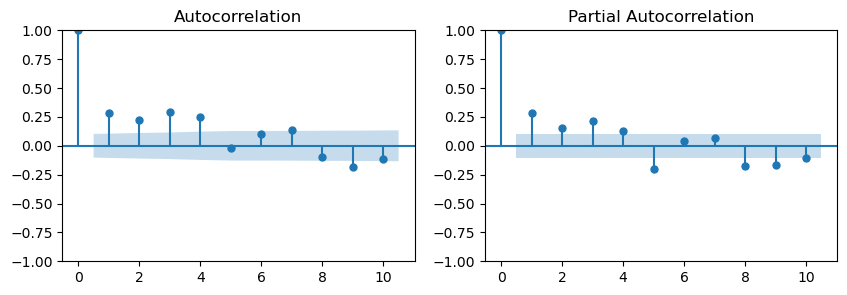

In [24]:
# Plot ACF and PACF charts.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
plot_acf(dfl, lags=10, ax=ax1)
plot_pacf(dfl, lags=10, ax=ax2, method='ywm')
plt.show()

Neither the Autocorrelation Function (ACF) nor the Partial Autocorrelation Function (PACF) show a clear tail, it makes our task to identify the appropriate orders (p and q) for the ARIMA model more challenging.  We'll use grid search to find out the best model using the lowest mean absolute percentage error.

In [25]:
# Build a base model and calculate mape.
arima = ARIMA(train, order=(0,1,0))
results = arima.fit()
prediction = results.get_forecast(steps=len(test)).predicted_mean
mape = mean_absolute_percentage_error(test, prediction)
print(mape)

3.268243977787207


In [26]:
# Grid search over p, d, q values to find the best combination
best_mape = mape
best_p, best_d, best_q = 0,0,0

for p in range(9):
    for d in range(3):
        for q in range(9):
            try:
                model = ARIMA(train, order=(p, d, q))
                results = model.fit()
                predictions = results.forecast(steps=len(test))
                mape = mean_absolute_percentage_error(test, predictions) 

                if mape < best_mape:
                    best_mape = mape
                    best_p, best_d, best_q = p, d, q
            except:
                pass

print("Best p:", best_p)
print("Best d:", best_d)
print("Best q:", best_q)
print("MAPE:", best_mape)

Best p: 8
Best d: 0
Best q: 6
MAPE: 3.0755771845763213


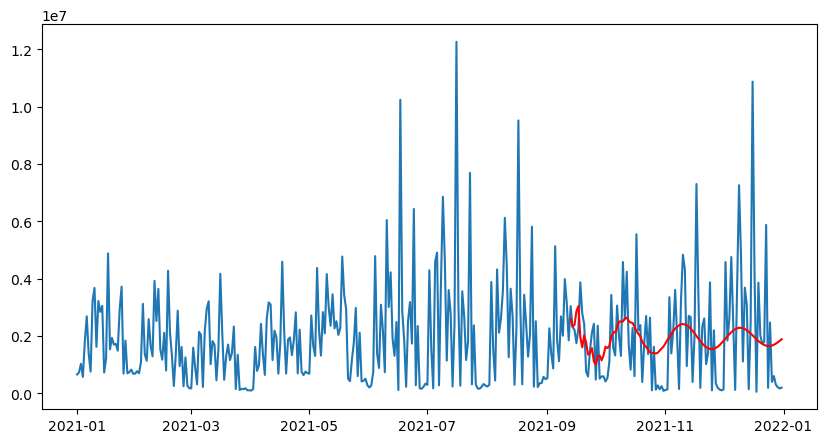

In [27]:
# Re-build the ARIMA model using p=8, d=0 and q=6.
arima = ARIMA(train, order=(8,0,6))
results = arima.fit()
prediction_arima = results.forecast(len(test))
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.values, label='observed')
plt.plot(prediction_arima.index, prediction_arima.values, color='red', label='prediction')
plt.show()

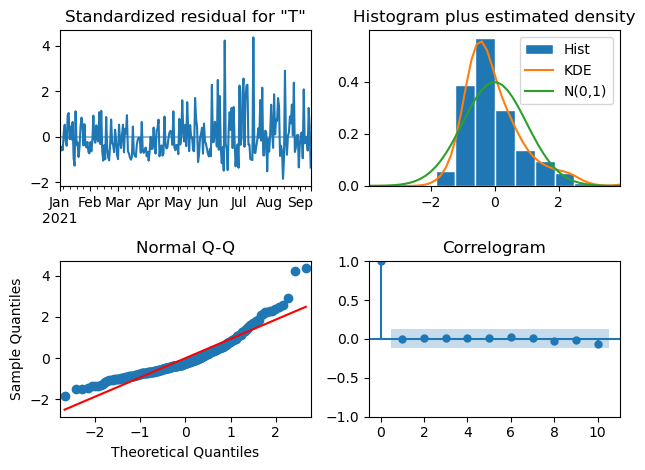

In [28]:
# Use model diagnostics to find out how good our model is.
results.plot_diagnostics()
plt.tight_layout()
plt.show()

In [29]:
mae_arima = mean_absolute_error(test, prediction_arima)
mse_arima = mean_squared_error(test, prediction_arima)
rmse_arima = np.sqrt(mse_arima)
mape_arima = mean_absolute_percentage_error(test, prediction_arima)
print("ARIMA Performance Metrics \n", "Mean Absolute Error: ", mae_arima, "\n", "Mean Squared Error: ", mse_arima, "\n", 
     "Root Mean Squared Error: ", rmse_arima, "\n", "Mean Absolute Percentage Error: ", mape_arima)

ARIMA Performance Metrics 
 Mean Absolute Error:  1279072.2982188824 
 Mean Squared Error:  3022111496841.727 
 Root Mean Squared Error:  1738422.1284951842 
 Mean Absolute Percentage Error:  3.0755771845763213


Now let's do cross validation to make sure that the model does work the way we want it to.

In [30]:
data = df.values

arimacv = TimeSeriesSplit(n_splits=5)
mape_scores = []
for train_idx, test_idx in arimacv.split(data):
    train_data = data[train_idx]
    test_data = data[test_idx]
    
    model = ARIMA(train_data, order=(8,0,6))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_data))
    mape = np.mean(np.abs((test_data - forecast) / test_data)) 
    mape_scores.append(mape)

avg_mape_arima = np.mean(mape_scores)
print("Cross Validation MAPE Scores: ", mape_scores)
print("Average MAPE:", avg_mape_arima)

Cross Validation MAPE Scores:  [2.567023333015952, 1.9151284409588316, 2.2455866103642372, 2.329639151907325, 4.04364531714707]
Average MAPE: 2.620204570678683


The above cross validation result shows that the arima model performs relatively stable.  The model is acceptable.

#### <span style="color:blue;">*2nd Model: Seasonable ARIMA*</span> 

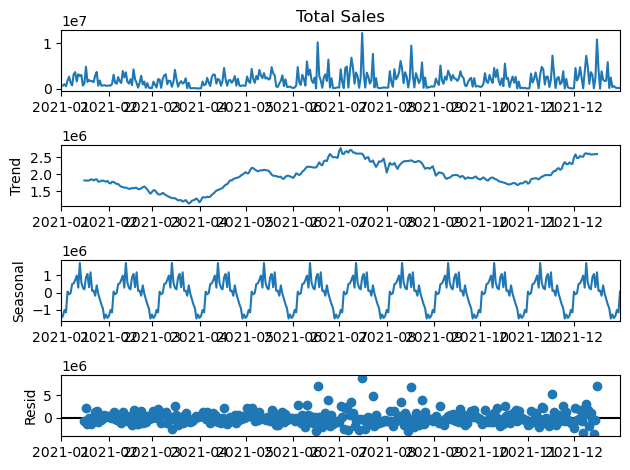

In [31]:
# Check seasonability of the time series.
decomp = seasonal_decompose(df['Total Sales'], period=30)
decomp.plot()
plt.show()

In [32]:
# De-trend time series.
df_dt = df - df.rolling(45).mean()
df_dt = df.dropna()

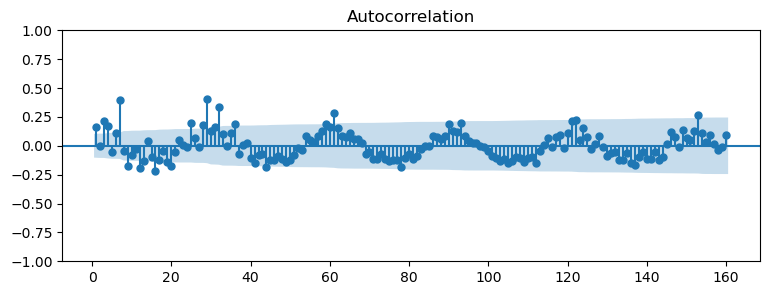

In [33]:
# Use ACF to identify sesaonsal data.
fig, ax = plt.subplots(1,1, figsize=(9,3))
plot_acf(df_dt, ax=ax, lags=160, zero=False)
plt.show()

Now, let's use auto_arima to find out the optimal hyperparameters that will give us the best model based upon the mape value.

In [34]:
results = pm.auto_arima(train, seasonal=True, m=30, max_d=2, max_D=2, information_criterion='aic', 
                        error_action='ignore', trace=True, stepwise=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=8031.708, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=8160.026, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8101.223, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=8034.011, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=8158.029, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=8029.938, Time=1.56 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=8029.079, Time=0.26 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=8029.742, Time=1.37 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=8023.847, Time=0.13 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=8025.083, Time=1.06 sec
 ARIMA(1,1,2)(0,0,1)[30] intercept   : AIC=8024.902, Time=0.87 sec
 ARIMA(1,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=8031.510, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=8033.583, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[30]

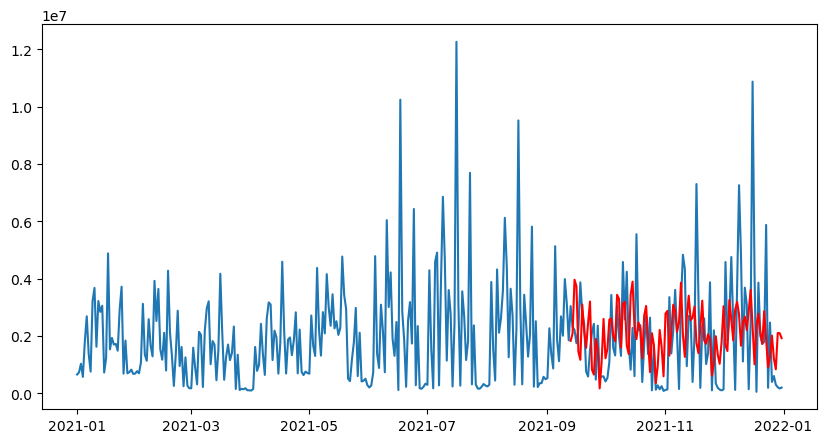

In [35]:
# Use the optimal order values obtained from the auto_arima to build and fit the best sarima model.
sarima = SARIMAX(train, order=(2,1,3), seasonal_order=(1,0,1,30))
results = sarima.fit()
prediction_sarima = results.forecast(steps = len(test))
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.values, label='observed')
plt.plot(prediction_sarima.index, prediction_sarima.values, color='red', label='predictinon')
plt.show()

In [36]:
mae_sarima = mean_absolute_error(test, prediction_sarima)
mse_sarima = mean_squared_error(test, prediction_sarima)
rmse_sarima = np.sqrt(mse_sarima)
mape_sarima = mean_absolute_percentage_error(test, prediction_sarima)
print("SARIMA Performance Metrics \n", "Mean Absolute Error: ", mae_sarima, "\n", "Mean Squared Error: ", mse_sarima, "\n", 
     "Root Mean Squared Error: ", rmse_sarima, "\n", "Mean Absolute Percentage Error: ", mape_sarima)

SARIMA Performance Metrics 
 Mean Absolute Error:  1453091.0212636057 
 Mean Squared Error:  3613974832364.362 
 Root Mean Squared Error:  1901045.7207453907 
 Mean Absolute Percentage Error:  3.365930585760102


In [37]:
data = df.values

sarimacv = TimeSeriesSplit(n_splits=5)
mape_scores = []
for train_idx, test_idx in sarimacv.split(data):
    train_data = data[train_idx]
    test_data = data[test_idx]
    
    model = SARIMAX(train_data, order=(2,1,3), seasonal_order=(1,0,1,30))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_data))
    mape = np.mean(np.abs((test_data - forecast) / test_data)) 
    mape_scores.append(mape)

avg_mape_sarima = np.mean(mape_scores)
print("Cross Validation MAPE Scores: ", mape_scores)
print("Average MAPE:", avg_mape_sarima)

Cross Validation MAPE Scores:  [2.653498018850375, 2.689891883690948, 2.311677823413611, 2.969288178583923, 3.5719972998668053]
Average MAPE: 2.8392706408811326


The average mape value from cross validation is relatively close to the mape value of the actual model.  Therefore, we conclude that the model is stable and will accept it. 

#### <span style="color:blue;">*3rd Model: Prophet*</span> 

Frist, we need to prepare the dataset for Prophet forecasting model training. Prophet has a specific requirement: the time column needs to be named as ‘ds’ and the value as ‘y’.

In [38]:
df_p = df.reset_index().rename(columns={"index": "ds", "Total Sales": "y"})

In [39]:
# Split df_p into training and testing sets.
df_p_train = df_p.iloc[:split_point]
df_p_test = df_p.iloc[split_point:]

In [40]:
# Build and fit the baseline model.  Use model to predict test data.
model_p = Prophet()
model_p.fit(df_p_train)
df_p_predict = model_p.predict(df_p_test)
df_p_predict.head()

13:57:11 - cmdstanpy - INFO - Chain [1] start processing
13:57:11 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-13,2.472981e+06,108057.675631,4.468439e+06,2.472981e+06,2.472981e+06,-204714.050758,-204714.050758,-204714.050758,-204714.050758,-204714.050758,-204714.050758,0.0,0.0,0.0,2.268267e+06
1,2021-09-14,2.477222e+06,792317.726062,5.085479e+06,2.477222e+06,2.477222e+06,521821.019683,521821.019683,521821.019683,521821.019683,521821.019683,521821.019683,0.0,0.0,0.0,2.999043e+06
2,2021-09-15,2.481463e+06,-36777.334070,4.246825e+06,2.481463e+06,2.481463e+06,-292711.018901,-292711.018901,-292711.018901,-292711.018901,-292711.018901,-292711.018901,0.0,0.0,0.0,2.188752e+06
3,2021-09-16,2.485704e+06,382896.008324,4.809567e+06,2.485704e+06,2.485704e+06,83073.720778,83073.720778,83073.720778,83073.720778,83073.720778,83073.720778,0.0,0.0,0.0,2.568778e+06
4,2021-09-17,2.489945e+06,669829.754474,5.091408e+06,2.489945e+06,2.489945e+06,445471.351236,445471.351236,445471.351236,445471.351236,445471.351236,445471.351236,0.0,0.0,0.0,2.935417e+06


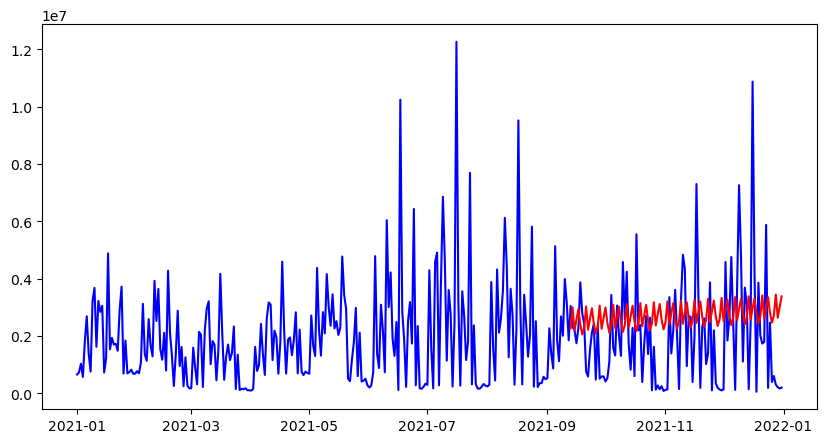

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(df_p['ds'], df_p['y'], color='blue', label='observed')
plt.plot(df_p_predict['ds'], df_p_predict['yhat'], color='red', label='prediction')
plt.show()

In [43]:
# Calculate model performance metrics.
mae_prophet = mean_absolute_error(df_p_test['y'], df_p_predict['yhat'])
mse_prophet = mean_squared_error(df_p_test['y'], df_p_predict['yhat']) 
rmse_prophet = np.sqrt(mse_prophet)
mape_prophet = mean_absolute_percentage_error(df_p_test['y'], df_p_predict['yhat']) 

print("Prophet Performance Metrics \n", "Mean Absolute Error: ", mae_prophet, "\n", "Mean Squared Error: ", mse_prophet, "\n", 
     "Root Mean Squared Error: ", rmse_prophet, "\n", "Mean Absolute Percentage Error: ", mape_prophet)

Prophet Performance Metrics 
 Mean Absolute Error:  1624540.565201017 
 Mean Squared Error:  4038370614352.083 
 Root Mean Squared Error:  2009569.7585184951 
 Mean Absolute Percentage Error:  5.044159422457962


Next, let's perform a grid search to find the optimal parameters for the best performing prophet model based on the MAPE value.

In [44]:
# Define the parameter grid for optimization
param_grid = {
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.001, 0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

best_mape = np.inf
best_params = {}

# Perform grid search with cross-validation
for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(df_p_train)
    forecast = model.predict(df_p_test)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(df_p_test['y'], forecast['yhat'])
    
    # Update the best parameters if the current model performs better
    if mape < best_mape:
        best_mape = mape
        best_params = params

print("Best Parameters:", best_params)
print("Best MAPE:", best_mape)


14:05:26 - cmdstanpy - INFO - Chain [1] start processing
14:05:26 - cmdstanpy - INFO - Chain [1] done processing
14:05:26 - cmdstanpy - INFO - Chain [1] start processing
14:05:26 - cmdstanpy - INFO - Chain [1] done processing
14:05:26 - cmdstanpy - INFO - Chain [1] start processing
14:05:26 - cmdstanpy - INFO - Chain [1] done processing
14:05:26 - cmdstanpy - INFO - Chain [1] start processing
14:05:27 - cmdstanpy - INFO - Chain [1] done processing
14:05:27 - cmdstanpy - INFO - Chain [1] start processing
14:05:27 - cmdstanpy - INFO - Chain [1] done processing
14:05:27 - cmdstanpy - INFO - Chain [1] start processing
14:05:27 - cmdstanpy - INFO - Chain [1] done processing
14:05:27 - cmdstanpy - INFO - Chain [1] start processing
14:05:27 - cmdstanpy - INFO - Chain [1] done processing
14:05:27 - cmdstanpy - INFO - Chain [1] start processing
14:05:27 - cmdstanpy - INFO - Chain [1] done processing
14:05:28 - cmdstanpy - INFO - Chain [1] start processing
14:05:28 - cmdstanpy - INFO - Chain [1]

14:05:42 - cmdstanpy - INFO - Chain [1] done processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
14:05:44 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing
14:05:44 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing
14:05:44 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing
14:05:44 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing
14:05:44 - cmdstanpy - INFO - Chain [1] 

Best Parameters: {'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Best MAPE: 1.9522369853710995


In [45]:
# Build and fit the best model.
model_p = Prophet(changepoint_prior_scale=1.0, holidays_prior_scale=0.001, seasonality_mode='multiplicative', 
                  seasonality_prior_scale=1.0)
model_p.fit(df_p_train)
df_p_predict = model_p.predict(df_p_test)

14:06:48 - cmdstanpy - INFO - Chain [1] start processing
14:06:48 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Calculate the best prophet model's performance metrics.
mae_prophet = mean_absolute_error(df_p_test['y'], df_p_predict['yhat'])
mse_prophet = mean_squared_error(df_p_test['y'], df_p_predict['yhat']) 
rmse_prophet = np.sqrt(mse_prophet)
mape_prophet = mean_absolute_percentage_error(df_p_test['y'], df_p_predict['yhat']) 

print("Prophet Performance Metrics \n", "Mean Absolute Error: ", mae_prophet, "\n", "Mean Squared Error: ", mse_prophet, "\n", 
     "Root Mean Squared Error: ", rmse_prophet, "\n", "Mean Absolute Percentage Error: ", mape_prophet)

Prophet Performance Metrics 
 Mean Absolute Error:  1449060.840520404 
 Mean Squared Error:  4392324889400.0522 
 Root Mean Squared Error:  2095787.4151258883 
 Mean Absolute Percentage Error:  1.9522369853710995


In [48]:
mape_scores = []

# Create TimeSeriesSplit object for cross-validation
prophetcv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
for train_index, test_index in prophetcv.split(df_p_train):
    train_data = df_p_train.iloc[train_index]
    test_data = df_p_train.iloc[test_index]

    model_p = Prophet(changepoint_prior_scale=1.0, holidays_prior_scale=0.01, seasonality_mode='multiplicative',
                      seasonality_prior_scale=1.0)
    model_p.fit(train_data)
    df_p_predict = model_p.predict(test_data)

    mape = mean_absolute_percentage_error(test_data['y'], df_p_predict['yhat'])
    mape_scores.append(mape)
    avg_mape_prophet = np.mean(mape_scores)

print("Cross Validation MAPE Scores: ", mape_scores)
print("Average MAPE:", avg_mape_prophet)

14:07:12 - cmdstanpy - INFO - Chain [1] start processing
14:07:12 - cmdstanpy - INFO - Chain [1] done processing
14:07:12 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing


Cross Validation MAPE Scores:  [6.565082265814673, 1.4665783091404012, 2.815420124757169, 5.384573576021491, 1.520925445719545]
Average MAPE: 3.550515944290656


While the average mape score from cross validation is a little bit higher than the mape score of the actual model, a closer look reveals that 3 out of the 5 cv mape scores are in line with the model mape score. When we look at the original sales chart for this time series, we can understand why the other 2 cross validation mape scores would be so high depending on the split point(s). Therefore, we'll accept the prophet model for now. 

#### <span style="color:blue;">*Comparison of Models*</span> 

We'll now review and compare the model metrics to pick the best performing model for our time series data.

In [49]:
# Create a pandas DataFrame to store the evaluation metrics
data = {
    'MAE': [mae_arima, mae_sarima, mae_prophet],
    'MSE': [mse_arima, mse_sarima, mse_prophet],
    'RMSE': [rmse_arima, rmse_sarima, rmse_prophet],
    'MAPE': [mape_arima, mape_sarima, mape_prophet],
    'CV AVG MAPE': [avg_mape_arima, avg_mape_sarima, avg_mape_prophet]
}

index = ['ARIMA', 'SARIMA', 'Prophet']
evaluation_table = pd.DataFrame(data, index=index)
evaluation_table

,MAE,MSE,RMSE,MAPE,CV AVG MAPE
ARIMA,1.279072e+06,3.022111e+12,1.738422e+06,3.075577,2.620205
SARIMA,1.453091e+06,3.613975e+12,1.901046e+06,3.365931,2.839271
Prophet,1.449061e+06,4.392325e+12,2.095787e+06,1.952237,3.550516


My initial thought is to pick the model with the lowest MAPE score.  Based upon this criteria, Prophet will be our model with a MAPE score of 1.95%.  However, when taking into consideration the other scores, I realize that Prophet might not be the best choice.  Despite the lowest MAPE score, the Prophet model has the highest MSE and 2nd highest MAE scores out of the 3 models.  Also, the Prophet model has the highest average MAPE score from cross validation with a much bigger variance in cv mape scores compared to the other two models.  Based upon these observations, I've decided not to pick Prophet as our best model.  Out of the ARIMA and SARIMA models, the ARIMA model has consistently better performance scores compared to SARIMA.  Therefore, our winner is the ARIMA model.  

#### 4.2.4 Conclusion

This is a time series problem, so I've tried the below 3 models specifically designed for time series datasets. 

1. ARIMA (AutoRegressive Integrated Moving Average)
2. SARIMA (Seasonal AutoRegressive Integrated Moving Average) 
3. Prophet

For the ARIMA and SARIMA models, since they are quite similar, our approach is almost the same. First, we built a baseline model using manually picked parameters and calculated performance scores such as mae, mse, rmse and mape for later comparison.  Then, we used grid search or auto_arima to find the optimal hyperparameters for the best model. Then, we trained the best model, fit it to the test data, calculated the performance scores and cross validated it using a 5-fold CV approach. 

Since Prophet is an open-source forecasting library developed by Facebook, our approach is slightly different.  There is an additional step in the beginning to re-process the data and transform it to an unique format specifically required by Prophet. After that, the process is very similar to the ARIMA and SARIMA models.   

After that, we evaluated and compared these models' performance scores including mae, mse, rmse and mape.  While we'd like to pick the model with the lowest mape value, we also took into consideration all the other factors to ensure the chosen model did perform better consistently.  Our final chice is the ARIMA model.  While its mape score isn't the lowest, it performs consistently better in all other aspects. 

Using the ARIMA model, we plotted the below sales forecasting chart based upon 2021 sales data.

<Figure size 1000x500 with 0 Axes>

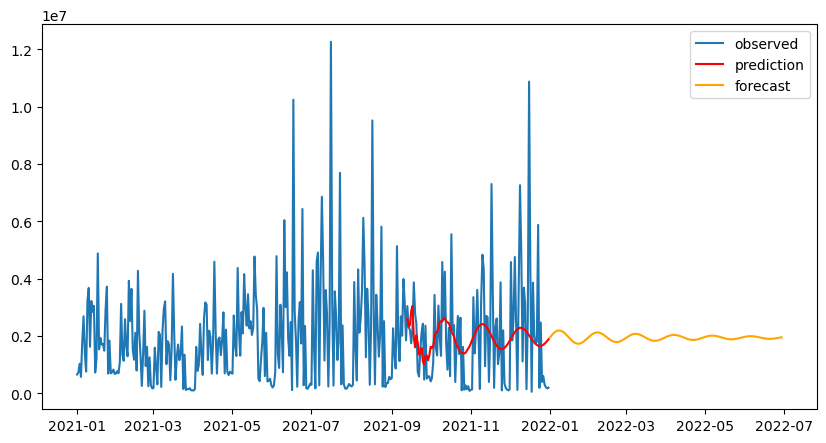

In [53]:
arima = ARIMA(train, order=(8,0,6))
results = arima.fit()
prediction_arima = results.forecast(len(test)+180)
plt.figure(figsize=(10, 5))
plt.figure(figsize=(10, 5))
plt.plot(df.index, df.values, label='observed')
plt.plot(prediction_arima.index[:len(test)], prediction_arima.values[:len(test)], color='red', label='prediction')
plt.plot(prediction_arima.index[len(test):], prediction_arima.values[len(test):], color='orange', label='forecast')  

plt.legend()
plt.show()
